In [6]:
import numpy as np
import os
import pickle
import time

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
def load_jets(root_dir, filename):
    """Load truth binary trees"""
    #root_dir = "../data/"
    filename = os.path.join(root_dir, filename)
    with open(filename + ".pkl", "rb") as fd:
        Truth= pickle.load(fd, encoding='latin-1')
    return Truth

In [253]:
gt_trees = load_jets("data", "ginkgo_10000_jets_no_cuts_lambda_21_pt_min_36_jetp_400_with_perm")  # My test file

## REMOVE THE TWO BAD JETS FROM THE 10k JET DATASET
arr = np.arange(len(gt_trees))
good_indices = arr[((arr != 4835) & (arr != 9024))]
gt_trees = (np.array(gt_trees)[good_indices]).tolist()

## Load leaf-based grid results

In [87]:
train_leaves_ix = [len(x["leaves"])-1 for x in gt_trees[:5000]]  # only use the first 5000 leaves

In [90]:
#fig, ax = plt.subplots(nrows=1, ncols=1)
#fig.set_size_inches(8,8)

n_cuts = 40
n_lambda = 40

cut_vals = np.linspace(26, 43, n_cuts)
lambda_vals = np.linspace(1.35, 2.4, n_lambda)
grid_cut, grid_lambda = np.meshgrid(cut_vals, lambda_vals)

max_LL = -np.inf
mle_params = None

likelihood_surface = np.zeros((n_lambda, n_cuts))

for i in range(n_cuts):
    for j in range(n_lambda):
        model_params = {"delta_min": grid_cut[j,i], "lam": grid_lambda[j,i]}
        
        histfile = "ginkgo_hist_20000_jets_jetp_400_lambda_{:n}_ptcut_{:n}_{}_{}.npy".format(
            int(grid_lambda[j,i])*1000,
            int(grid_cut[j,i]),
            j,
            i)

        log_dist = np.log(np.load(os.path.join("/scratch/mdd424/data/ginkgo", histfile)))
        
        likelihood = 0
        for ix in train_leaves_ix:
            likelihood += log_dist[ix]
        
        likelihood_surface[j,i] = likelihood
        if likelihood > max_LL:
            max_LL = likelihood
            mle_params = {"delta_min": grid_cut[j,i], "lam": grid_lambda[j,i]}

<ipython-input-90-2e456ff5a356>:26: RuntimeWarning: divide by zero encountered in log
  log_dist = np.log(np.load(os.path.join("/scratch/mdd424/data/ginkgo", histfile)))


In [91]:
np.save("data/likelihood_fit_on_leaves_ginkgo_1000_jets_lambda_21_pt_min_36_jetp_400.npy", likelihood_surface)

## Load trellis grid results

In [14]:
time.time()

1624644832.3513608

In [109]:
def get_likelihood_surface(cut_min, cut_max, n_cuts,
                           lambda_min, lambda_max, n_lambda,
                           subsample=None,
                           seed=None,
                           likelihood="marginal",
                           datadir="/scratch/mdd424/data/trellis"):
    
    if likelihood.lower() == "marginal":
        key = "Z"
    elif likelihood.lower() == "map":
        key = "trellis_MLE"
    else:
        return None
    
    cut_vals = np.linspace(cut_min, cut_max, n_cuts)
    lambda_vals = np.linspace(lambda_min, lambda_max, n_lambda)
    
    grid_cut, grid_lambda = np.meshgrid(cut_vals, lambda_vals)
    
    likelihood_surface = np.zeros((n_lambda, n_cuts))
    
    if subsample is not None:
        if seed is None:
            np.random.seed(int(time.time()*1000) % 2**32)
        else:
            np.random.seed(seed)

    for i in range(n_cuts):
        for j in range(n_lambda):
            model_params = {"delta_min": grid_cut[j,i], "lam": grid_lambda[j,i]}

            in_filename = os.path.join(datadir, "trellis_10000_jets_lambda_{:n}_ptcut_{:n}_{}_{}_with_perm.pkl".format(
                int(grid_lambda[j,i])*1000,
                int(grid_cut[j,i]),
                j,
                i))
            with open(in_filename, "rb") as fd:
                results = pickle.load(fd, encoding='latin-1')
                
            ## REMOVE THE TWO BAD JETS FROM THE 10k JET DATASET
            myresults = np.array(results[key])
            arr = np.arange(len(myresults))
            good_indices = ((arr != 4835) & (arr != 9024))
            myresults = myresults[good_indices]

            if subsample is not None:
                total_Z = np.sum(np.random.choice(myresults, subsample, replace=False))
            else:
                total_Z = np.sum(myresults)
                
            likelihood_surface[j,i] = total_Z
                
    return likelihood_surface

In [127]:
def get_likelihood_surface_array(cut_min, cut_max, n_cuts,
                                 lambda_min, lambda_max, n_lambda,
                                 Njets=10000,
                                 likelihood="marginal",
                                 datadir="/scratch/mdd424/data/trellis"):
    
    if likelihood.lower() == "marginal":
        key = "Z"
    elif likelihood.lower() == "map":
        key = "trellis_MLE"
    else:
        return None
    
    cut_vals = np.linspace(cut_min, cut_max, n_cuts)
    lambda_vals = np.linspace(lambda_min, lambda_max, n_lambda)
    
    grid_cut, grid_lambda = np.meshgrid(cut_vals, lambda_vals)
    
    likelihood_surface = np.zeros((Njets, n_lambda, n_cuts))

    for i in range(n_cuts):
        for j in range(n_lambda):
            model_params = {"delta_min": grid_cut[j,i], "lam": grid_lambda[j,i]}

            in_filename = os.path.join(datadir, "trellis_10000_jets_lambda_{:n}_ptcut_{:n}_{}_{}_with_perm.pkl".format(
                int(grid_lambda[j,i])*1000,
                int(grid_cut[j,i]),
                j,
                i))
            with open(in_filename, "rb") as fd:
                results = pickle.load(fd, encoding='latin-1')
                
            ## REMOVE THE TWO BAD JETS FROM THE 10k JET DATASET
            #myresults = np.array(results[key])
            #arr = np.arange(len(myresults))
            #good_indices = ((arr != 4835) & (arr != 9024))
            #myresults = myresults[good_indices]
            
            for k in range(Njets):
                likelihood_surface[k,j,i] = results[key][k]
                
    return likelihood_surface

In [110]:
n_cuts = 40
n_lambda = 40
N_jets = 5000

#cut_min = 4
#cut_max = 90
#lambda_min = 1e-1
#lambda_max = 5

#cut_min = 26
#cut_max = 43
cut_min = 33
cut_max = 38
lambda_min = 1.35
lambda_max = 2.4

cut_vals = np.linspace(cut_min, cut_max, n_cuts)
lambda_vals = np.linspace(lambda_min, lambda_max, n_lambda)
grid_cut, grid_lambda = np.meshgrid(cut_vals, lambda_vals)

In [101]:
seed = int(time.time()*1000) % 2**32

### THERE ARE TWO BAD JETS WITH INDICES (starting from 0)
- 4835
- 9024

In [102]:
arr = np.arange(10000)
((arr != 4835) & (arr != 9024)).sum()

9998

In [111]:
likelihood_surface = get_likelihood_surface(cut_min, cut_max, n_cuts,
                                            lambda_min, lambda_max, n_lambda,
                                            likelihood="marginal",
                                            subsample=None,
                                            seed=seed)

In [113]:
likelihood_map_surface = get_likelihood_surface(cut_min, cut_max, n_cuts,
                                                lambda_min, lambda_max, n_lambda,
                                                likelihood="MAP",
                                                subsample=None,
                                                seed=seed)

In [55]:
np.save("data/likelihood_fit_trellis_ginkgo_1000_jets_lambda_21_pt_min_36_jetp_400_with_perm.npy", likelihood_surface)

In [56]:
np.save("data/likelihood_fit_trellis_map_ginkgo_1000_jets_lambda_21_pt_min_36_jetp_400_with_perm.npy", likelihood_map_surface)

## Look at Results

In [18]:
n_cuts = 40
n_lambda = 40
N_jets = 5000

#cut_min = 4
#cut_max = 90
#lambda_min = 1e-1
#lambda_max = 5

#cut_min = 26
#cut_max = 43
cut_min = 33
cut_max = 38
lambda_min = 1.35
lambda_max = 2.4

cut_vals = np.linspace(cut_min, cut_max, n_cuts)
lambda_vals = np.linspace(lambda_min, lambda_max, n_lambda)
grid_cut, grid_lambda = np.meshgrid(cut_vals, lambda_vals)

### Load results from fitting just based on leaves

In [142]:
leaf_likelihood_surface = np.load("data/likelihood_fit_on_leaves_ginkgo_1000_jets_lambda_21_pt_min_36_jetp_400.npy")

In [36]:
leaf_likelihood_surface[np.isnan(leaf_likelihood_surface)] = -np.inf
mle_leaf_coords = np.unravel_index(np.argmax(leaf_likelihood_surface, axis=None), leaf_likelihood_surface.shape)
mle_leaf_coords

NameError: name 'leaf_likelihood_surface' is not defined

In [144]:
lambda_vals[mle_leaf_coords[0]], cut_vals[mle_leaf_coords[1]]

(1.9692307692307693, 38.64102564102564)

### Load results from Trellis MLE fit

In [27]:
likelihood_surface = np.load("data/likelihood_fit_trellis_ginkgo_1000_jets_lambda_21_pt_min_36_jetp_400_with_perm.npy")

In [114]:
mle_coords = np.unravel_index(np.argmax(likelihood_surface[~np.isnan(likelihood_surface)], axis=None), likelihood_surface.shape)
mle_coords

(4, 24)

In [115]:
lambda_vals[mle_coords[0]], cut_vals[mle_coords[1]]

(1.4576923076923078, 36.07692307692308)

### Load results from Trellis MAP MLE fit

In [31]:
likelihood_map_surface = np.load("data/likelihood_fit_trellis_map_ginkgo_1000_jets_lambda_21_pt_min_36_jetp_400_with_perm.npy")

In [116]:
mle_map_coords = np.unravel_index(np.argmax(likelihood_map_surface[~np.isnan(likelihood_map_surface)], axis=None), likelihood_map_surface.shape)
mle_map_coords

(19, 24)

In [117]:
lambda_vals[mle_map_coords[0]], cut_vals[mle_map_coords[1]]

(1.8615384615384616, 36.07692307692308)

### Get truth results

In [164]:
truth_bin = [None, None]
for ix, x in enumerate(cut_vals >= 36):
    if x.item() is True:
        truth_bin[0] = ix-1
        break
        
for ix, x in enumerate(lambda_vals >= 2.1):
    if x.item() is True:
        truth_bin[1] = ix-1
        break
        
print(truth_bin)

[23, 27]


In [119]:
lambda_vals[truth_bin[1]], cut_vals[truth_bin[0]]

(2.0769230769230766, 35.94871794871795)

# Plot results for Trellis Likelihoods

### MLE values

In [120]:
mle_coords = np.unravel_index(np.argmax(likelihood_surface[~np.isnan(likelihood_surface)], axis=None), likelihood_surface.shape)
mle_coords

(4, 24)

In [121]:
mle_map_coords = np.unravel_index(np.argmax(likelihood_map_surface[~np.isnan(likelihood_map_surface)], axis=None), likelihood_map_surface.shape)
mle_map_coords

(19, 24)

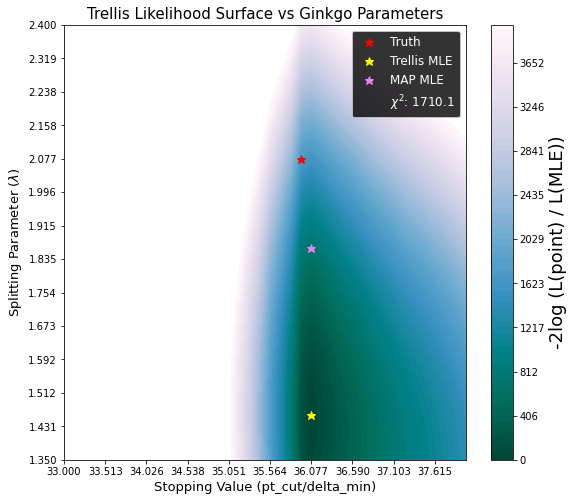

In [123]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,8)

Z = -2*(likelihood_surface-likelihood_surface[mle_coords])

chi2_marginal = Z[truth_bin[1], truth_bin[0]]

# Boost the upper limit to avoid truncation errors.
levels = -2*np.flip(np.linspace(-2, 0, 70))*1000

cset1 = ax.contourf(grid_cut, grid_lambda, Z,
                    levels, cmap="PuBuGn_r")
cb = fig.colorbar(cset1, ax=ax)
cb.set_label(label="-2log (L(point) / L(MLE))", size=18)

ax.plot(cut_vals[truth_bin[0]], lambda_vals[truth_bin[1]], "*", color="red", markersize=9, label="Truth")
ax.plot(cut_vals[mle_coords[1]], lambda_vals[mle_coords[0]], "*", color="yellow", markersize=9, label="Trellis MLE")
#ax.plot(cut_vals[mle_leaf_coords[1]], lambda_vals[mle_leaf_coords[0]], "*", color="orange", markersize=9, label="Leaf MLE")
ax.plot(cut_vals[mle_map_coords[1]], lambda_vals[mle_map_coords[0]], "*", color="violet", markersize=9, label="MAP MLE")
ax.plot([], [], ' ', label="$\chi^2$: {:.1f}".format(chi2_marginal))

ax.legend(labelcolor="white", facecolor="black", fontsize="large")

ax.set_title("Trellis Likelihood Surface vs Ginkgo Parameters", size=15)
ax.set_xlabel("Stopping Value (pt_cut/delta_min)", size=13)
ax.set_ylabel("Splitting Parameter ($\lambda$)", size=13)
#ax.set_yscale("log")
ax.set_xticks(cut_vals[::4])
ax.set_yticks(lambda_vals[::3]);

### Plot results for Trellis MAP Likelihood

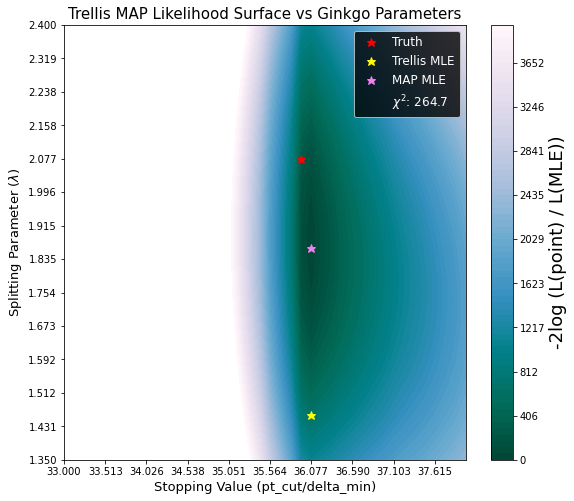

In [124]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,8)

Z = -2*(likelihood_map_surface-likelihood_map_surface[mle_map_coords])

chi2_map = Z[truth_bin[1], truth_bin[0]]

# Boost the upper limit to avoid truncation errors.
levels = -2*np.flip(np.linspace(-2, 0, 70))*1000

cset1 = ax.contourf(grid_cut, grid_lambda, Z,
                    levels, cmap="PuBuGn_r")
cb = fig.colorbar(cset1, ax=ax)
cb.set_label(label="-2log (L(point) / L(MLE))", size=18)

ax.plot(cut_vals[truth_bin[0]], lambda_vals[truth_bin[1]], "*", color="red", markersize=9, label="Truth")
ax.plot(cut_vals[mle_coords[1]], lambda_vals[mle_coords[0]], "*", color="yellow", markersize=9, label="Trellis MLE")
#ax.plot(cut_vals[mle_leaf_coords[1]], lambda_vals[mle_leaf_coords[0]], "*", color="orange", markersize=9, label="Leaf MLE")
ax.plot(cut_vals[mle_map_coords[1]], lambda_vals[mle_map_coords[0]], "*", color="violet", markersize=9, label="MAP MLE")
#Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0, label="$\chi^2$")
ax.plot([], [], ' ', label="$\chi^2$: {:.1f}".format(chi2_map))

ax.legend(labelcolor="white", facecolor="black", fontsize="large")

ax.set_title("Trellis MAP Likelihood Surface vs Ginkgo Parameters", size=15)
ax.set_xlabel("Stopping Value (pt_cut/delta_min)", size=13)
ax.set_ylabel("Splitting Parameter ($\lambda$)", size=13)
#ax.set_yscale("log")
ax.set_xticks(cut_vals[::4])
ax.set_yticks(lambda_vals[::3]);

### Plot results for Leaf-based Likelihoods

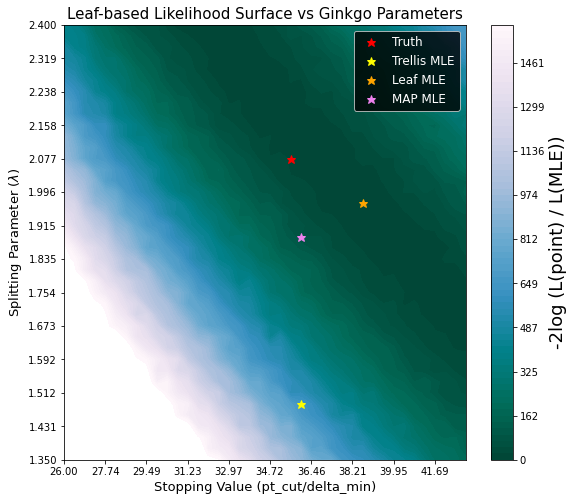

In [163]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,8)

Z = -2*(leaf_likelihood_surface-leaf_likelihood_surface[mle_leaf_coords])

# Boost the upper limit to avoid truncation errors.
levels = -2*np.flip(np.linspace(-0.8, 0, 70))*1000

cset1 = ax.contourf(grid_cut, grid_lambda, Z,
                    levels, cmap="PuBuGn_r")
cb = fig.colorbar(cset1, ax=ax)
cb.set_label(label="-2log (L(point) / L(MLE))", size=18)

ax.plot(cut_vals[truth_bin[0]], lambda_vals[truth_bin[1]], "*", color="red", markersize=9, label="Truth")
ax.plot(cut_vals[mle_coords[1]], lambda_vals[mle_coords[0]], "*", color="yellow", markersize=9, label="Trellis MLE")
ax.plot(cut_vals[mle_leaf_coords[1]], lambda_vals[mle_leaf_coords[0]], "*", color="orange", markersize=9, label="Leaf MLE")
ax.plot(cut_vals[mle_map_coords[1]], lambda_vals[mle_map_coords[0]], "*", color="violet", markersize=9, label="MAP MLE")

ax.legend(labelcolor="white", facecolor="black", fontsize="large")

ax.set_title("Leaf-based Likelihood Surface vs Ginkgo Parameters", size=15)
ax.set_xlabel("Stopping Value (pt_cut/delta_min)", size=13)
ax.set_ylabel("Splitting Parameter ($\lambda$)", size=13)
#ax.set_yscale("log")
ax.set_xticks(cut_vals[::4])
ax.set_yticks(lambda_vals[::3]);

## Look at the distribution of number of leaves at the three points

In [159]:
trellis_mle_jets = load_jets("/scratch/mdd424/data/ginkgo", "ginkgo_20000_jets_jetp_400_lambda_{:n}_ptcut_{:n}_{}_{}".format(
    int(grid_lambda[mle_coords])*1000,
    int(grid_cut[mle_coords]),
    mle_coords[0],
    mle_coords[1]))

In [160]:
leaf_mle_jets = load_jets("/scratch/mdd424/data/ginkgo", "ginkgo_20000_jets_jetp_400_lambda_{:n}_ptcut_{:n}_{}_{}".format(
    int(grid_lambda[mle_leaf_coords])*1000,
    int(grid_cut[mle_leaf_coords]),
    mle_leaf_coords[0],
    mle_leaf_coords[1]))

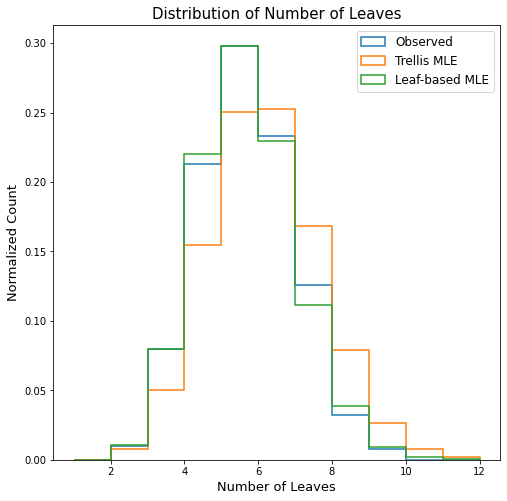

In [161]:
truth_num_leaves = [len(x["leaves"]) for x in gt_trees[:1000]]
trellis_num_leaves = [len(x["leaves"]) for x in trellis_mle_jets]
leaf_num_leaves = [len(x["leaves"]) for x in leaf_mle_jets]

#mle_num_leaves = [len(x["leaves"]) for x in mle_gt_trees]
#print(np.min(mle_num_leaves), np.max(mle_num_leaves))

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(8,8)

ax.hist(truth_num_leaves, bins=np.arange(1,13), histtype="step", linewidth=1.5, density=True, label="Observed")
ax.hist(trellis_num_leaves, bins=np.arange(1,13), histtype="step", linewidth=1.5,  density=True, label="Trellis MLE")
ax.hist(leaf_num_leaves, bins=np.arange(1,13), histtype="step", linewidth=1.5, density=True, label="Leaf-based MLE")

ax.set_xlabel("Number of Leaves", size=13)
ax.set_ylabel("Normalized Count", size=13)
ax.set_title("Distribution of Number of Leaves", size=15)
ax.legend(fontsize="large")

In [162]:
np.mean(truth_num_leaves), np.mean(trellis_num_leaves)

(5.21, 5.7086)

## Load in the means of the number of leaves at each grid point (outdated grid scan)

In [139]:
mean_leaves = np.load("data/ginkgo_8000_jets_grid_mean_num_leaves.npy")

In [140]:
truth_num_leaves = [len(x["leaves"]) for x in gt_trees[:1000]]
truth_mean_leaves = np.mean(truth_num_leaves)
truth_std_leaves = np.std(truth_num_leaves)

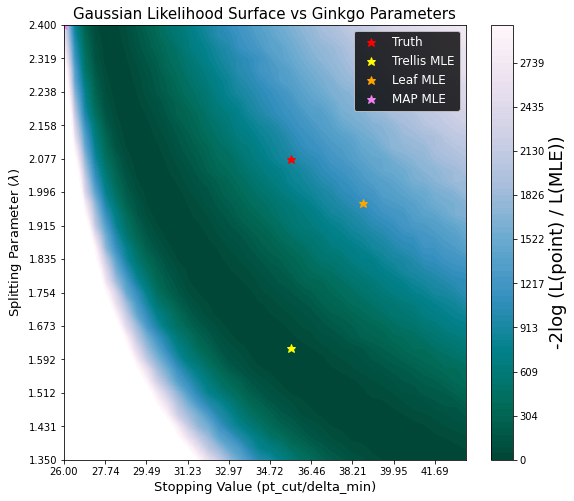

In [141]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,8)

Z = 1000*pow(mean_leaves - truth_mean_leaves, 2) / pow(truth_std_leaves, 2)

# Boost the upper limit to avoid truncation errors.
levels = -2*np.flip(np.linspace(-1.5, 0, 70))*1000

cset1 = ax.contourf(grid_cut, grid_lambda, Z,
                    levels, cmap="PuBuGn_r")
cb = fig.colorbar(cset1, ax=ax)
cb.set_label(label="-2log (L(point) / L(MLE))", size=18)

ax.plot(cut_vals[truth_bin[0]], lambda_vals[truth_bin[1]], "*", color="red", markersize=9, label="Truth")
ax.plot(cut_vals[mle_coords[1]], lambda_vals[mle_coords[0]], "*", color="yellow", markersize=9, label="Trellis MLE")
ax.plot(cut_vals[mle_leaf_coords[1]], lambda_vals[mle_leaf_coords[0]], "*", color="orange", markersize=9, label="Leaf MLE")
ax.plot(cut_vals[mle_map_coords[1]], lambda_vals[mle_map_coords[0]], "*", color="violet", markersize=9, label="MAP MLE")

ax.legend(labelcolor="white", facecolor="black", fontsize="large")

ax.set_title("Gaussian Likelihood Surface vs Ginkgo Parameters", size=15)
ax.set_xlabel("Stopping Value (pt_cut/delta_min)", size=13)
ax.set_ylabel("Splitting Parameter ($\lambda$)", size=13)
#ax.set_yscale("log")
ax.set_xticks(cut_vals[::4])
ax.set_yticks(lambda_vals[::3]);

# Look at fit results across several minibatches

In [7]:
n_cuts = 40
n_lambda = 40
N_jets = 5000

#cut_min = 4
#cut_max = 90
#lambda_min = 1e-1
#lambda_max = 5

cut_min = 26
cut_max = 43
lambda_min = 1.35
lambda_max = 2.4

cut_vals = np.linspace(cut_min, cut_max, n_cuts)
lambda_vals = np.linspace(lambda_min, lambda_max, n_lambda)
grid_cut, grid_lambda = np.meshgrid(cut_vals, lambda_vals)

### Save all of the likelihood surfaces to clean up files

In [11]:
for seed in range(50):
    batch_likelihood_surface = get_likelihood_surface(cut_min, cut_max, n_cuts,
                                                lambda_min, lambda_max, n_lambda,
                                                likelihood="marginal",
                                                datadir="/scratch/mdd424/data/trellis/batch" + str(seed))
    np.save(os.path.join("/scratch/mdd424/data/trellis/likelihood",
                         "likelihood_fit_trellis_ginkgo_batch{}_1000_jets_lambda_21_pt_min_36_jetp_400.npy".format(seed)),
            batch_likelihood_surface)

### Load all of the likelihood surfaces

In [148]:
likelihood_surface_array = get_likelihood_surface_array(cut_min, cut_max, n_cuts,
                                                        lambda_min, lambda_max, n_lambda,
                                                        likelihood="marginal")
## REMOVE THE TWO BAD JETS FROM THE 10k JET DATASET
arr = np.arange(likelihood_surface_array.shape[0])
good_indices = arr[((arr != 4835) & (arr != 9024))]
likelihood_surface_array = likelihood_surface_array[good_indices]

In [156]:
lambda_dist = []
ptcut_dist = []
batch_mle_coords = []

for seed in range(100):
    np.random.seed(seed)
    
    arr = np.arange(likelihood_surface_array.shape[0])
    random_indices = np.random.choice(arr, 1000, replace=False)
    
    batch_likelihood_surface = np.sum(likelihood_surface_array[random_indices], axis=0)
    
    mle_coords = np.unravel_index(np.argmax(batch_likelihood_surface[~np.isnan(batch_likelihood_surface)], axis=None),
                                  batch_likelihood_surface.shape)
    batch_mle_coords.append(mle_coords)
    lambda_dist.append(lambda_vals[mle_coords[0]])
    ptcut_dist.append(cut_vals[mle_coords[1]])
        
lambda_dist = np.array(lambda_dist)
ptcut_dist = np.array(ptcut_dist)

In [157]:
lambda_min_bin = 0
lambda_max_bin = 0
ptcut_min_bin = 0
ptcut_max_bin = 0

for ix, x in enumerate(lambda_vals == np.min(lambda_dist[lambda_dist != None])):
    if x.item() is True:
        lambda_min_bin = ix
        break
        
for ix, x in enumerate(lambda_vals == np.max(lambda_dist[lambda_dist != None])):
    if x.item() is True:
        lambda_max_bin = ix
        break
        
for ix, x in enumerate(cut_vals == np.min(ptcut_dist[ptcut_dist != None])):
    if x.item() is True:
        ptcut_min_bin = ix
        break
        
for ix, x in enumerate(cut_vals == np.max(ptcut_dist[ptcut_dist != None])):
    if x.item() is True:
        ptcut_max_bin = ix
        break
        
lambda_hist_bins = lambda_vals[lambda_min_bin:lambda_max_bin+2]
ptcut_hist_bins = cut_vals[ptcut_min_bin:ptcut_max_bin+2]

Text(0.5, 0.98, 'Distribution of Parameter MLEs')

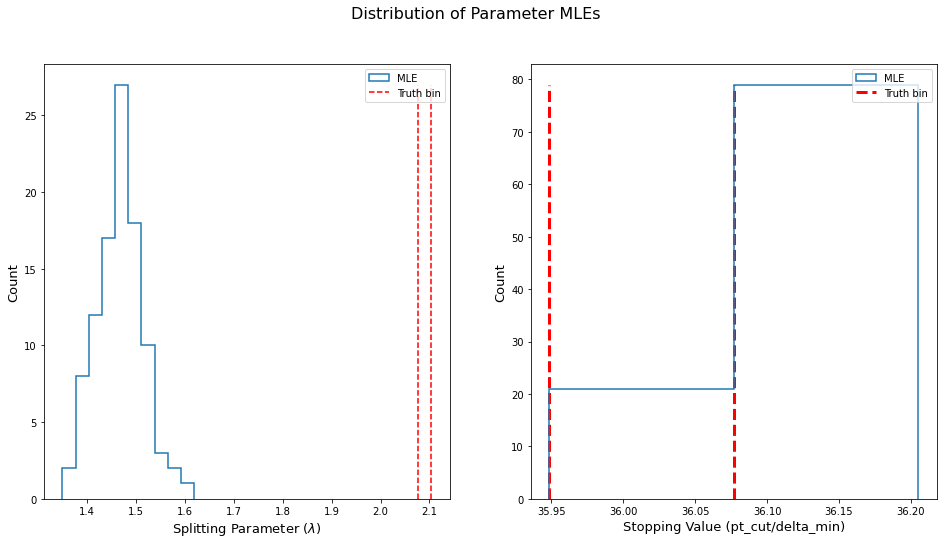

In [158]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16,8)

hist1 = ax1.hist(lambda_dist[lambda_dist != None],
                 bins=lambda_hist_bins,
                 histtype="step", linewidth=1.5, label="MLE")
hist2 = ax2.hist(ptcut_dist[ptcut_dist != None],
                 bins=ptcut_hist_bins,
                 histtype="step", linewidth=1.5, label="MLE")

ax1.vlines(lambda_vals[truth_bin[1]], ymin=0, ymax=np.max(hist1[0]), colors="red", linestyle="dashed",
           linewidth=1.5, label="Truth bin")
ax1.vlines(lambda_vals[truth_bin[1]+1], ymin=0, ymax=np.max(hist1[0]), colors="red", linestyle="dashed", linewidth=1.5)
ax2.vlines(cut_vals[truth_bin[0]], ymin=0, ymax=np.max(hist2[0]), colors="red", linestyle="dashed",
           linewidth=3, label="Truth bin")
ax2.vlines(cut_vals[truth_bin[0]+1], ymin=0, ymax=np.max(hist2[0]), colors="red", linestyle="dashed", linewidth=3)

ax1.legend()
ax2.legend()

ax1.set_xlabel("Splitting Parameter ($\lambda$)", size=13)
ax2.set_xlabel("Stopping Value (pt_cut/delta_min)", size=13)
ax1.set_ylabel("Count", size=13)
ax2.set_ylabel("Count", size=13)
fig.suptitle("Distribution of Parameter MLEs", size=16)
#ax1.set_title("Distribution of Jet Likelihoods", size=15)

In [159]:
np.var([x for x in lambda_dist if x is not None]), np.var([x for x in ptcut_dist if x is not None])

(0.0022420399408284012, 0.0027268244575938206)

In [160]:
total_likelihood_surface = np.sum(likelihood_surface_array, axis=0)

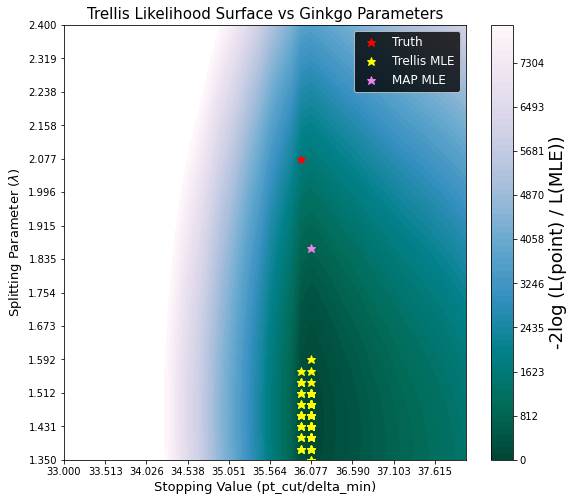

In [161]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,8)

Z = -2*(total_likelihood_surface-total_likelihood_surface.max())

# Boost the upper limit to avoid truncation errors.
levels = -2*np.flip(np.linspace(-4, 0, 70))*1000

cset1 = ax.contourf(grid_cut, grid_lambda, Z,
                    levels, cmap="PuBuGn_r")
cb = fig.colorbar(cset1, ax=ax)
cb.set_label(label="-2log (L(point) / L(MLE))", size=18)

ax.plot(cut_vals[truth_bin[0]], lambda_vals[truth_bin[1]], "*", color="red", markersize=9, label="Truth")
ax.plot(cut_vals[mle_coords[1]], lambda_vals[mle_coords[0]], "*", color="yellow", markersize=9, label="Trellis MLE")
for coords in batch_mle_coords:
    ax.plot(cut_vals[coords[1]], lambda_vals[coords[0]], "*", color="yellow", markersize=9)
#ax.plot(cut_vals[mle_leaf_coords[1]], lambda_vals[mle_leaf_coords[0]], "*", color="orange", markersize=9, label="Leaf MLE")
ax.plot(cut_vals[mle_map_coords[1]], lambda_vals[mle_map_coords[0]], "*", color="violet", markersize=9, label="MAP MLE")

ax.legend(labelcolor="white", facecolor="black", fontsize="large")

ax.set_title("Trellis Likelihood Surface vs Ginkgo Parameters", size=15)
ax.set_xlabel("Stopping Value (pt_cut/delta_min)", size=13)
ax.set_ylabel("Splitting Parameter ($\lambda$)", size=13)
#ax.set_yscale("log")
ax.set_xticks(cut_vals[::4])
ax.set_yticks(lambda_vals[::3]);

## Look at some individual jets

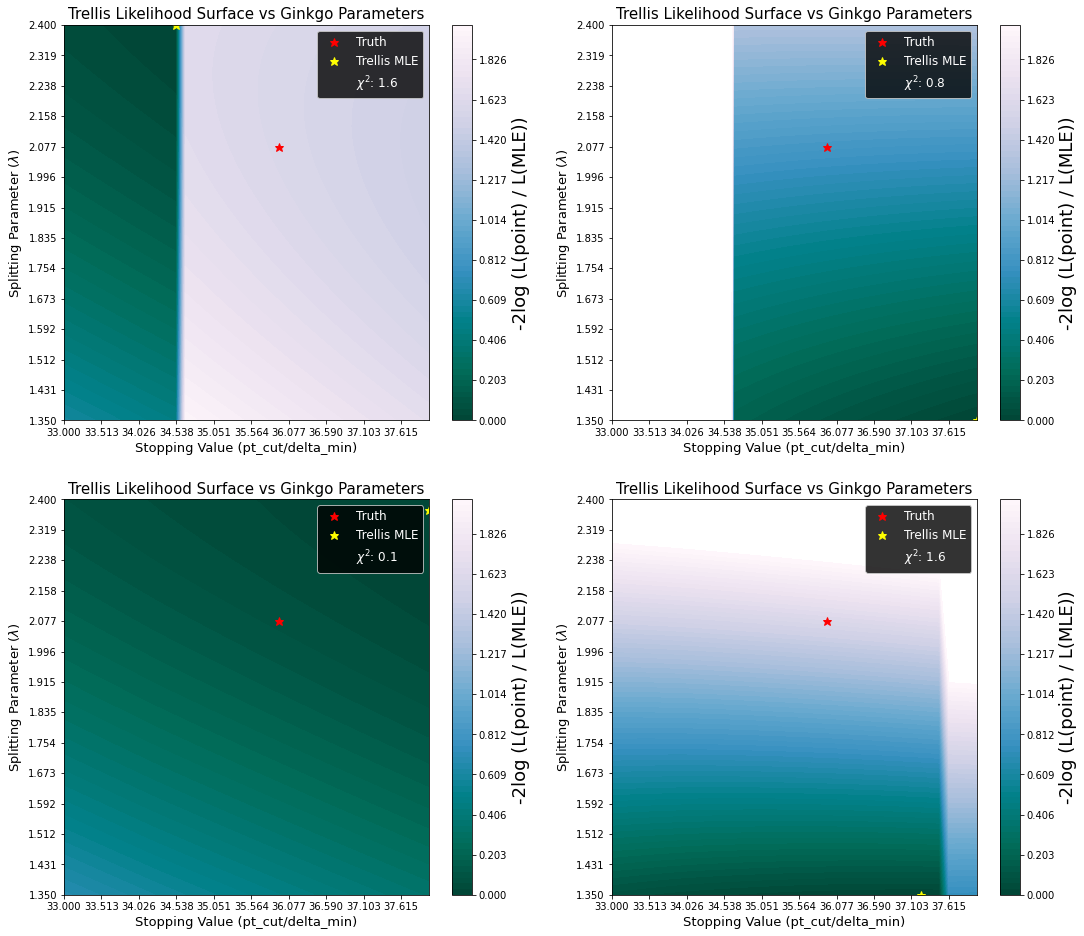

In [174]:
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(18,16)

np.random.seed(int(time.time()*1000) % 2**32)

for ax_x in range(2):
    for ax_y in range(2):
        
        rand_jet = np.random.choice(np.arange(likelihood_surface_array.shape[0]))
        rand_likelihood_surface = likelihood_surface_array[rand_jet]
        
        rand_mle_coords = np.unravel_index(np.argmax(rand_likelihood_surface[~np.isnan(rand_likelihood_surface)], axis=None), rand_likelihood_surface.shape)

        Z = -2*(rand_likelihood_surface-rand_likelihood_surface[rand_mle_coords])

        chi2_marginal = Z[truth_bin[1], truth_bin[0]]

        # Boost the upper limit to avoid truncation errors.
        levels = -2*np.flip(np.linspace(-0.001, 0, 70))*1000

        # Contour plot
        cset1 = ax[ax_x,ax_y].contourf(grid_cut, grid_lambda, Z,
                            levels, cmap="PuBuGn_r")
        cb = fig.colorbar(cset1, ax=ax[ax_x,ax_y])
        cb.set_label(label="-2log (L(point) / L(MLE))", size=18)

        ax[ax_x,ax_y].plot(cut_vals[truth_bin[0]], lambda_vals[truth_bin[1]], "*", color="red", markersize=9, label="Truth")
        ax[ax_x,ax_y].plot(cut_vals[rand_mle_coords[1]], lambda_vals[rand_mle_coords[0]], "*", color="yellow", markersize=9, label="Trellis MLE")
        #ax.plot(cut_vals[mle_leaf_coords[1]], lambda_vals[mle_leaf_coords[0]], "*", color="orange", markersize=9, label="Leaf MLE")
        #ax[ax_x,ax_y].plot(cut_vals[mle_map_coords[1]], lambda_vals[mle_map_coords[0]], "*", color="violet", markersize=9, label="MAP MLE")
        ax[ax_x,ax_y].plot([], [], ' ', label="$\chi^2$: {:.1f}".format(chi2_marginal))

        ax[ax_x,ax_y].legend(labelcolor="white", facecolor="black", fontsize="large")

        ax[ax_x,ax_y].set_title("Trellis Likelihood Surface vs Ginkgo Parameters", size=15)
        ax[ax_x,ax_y].set_xlabel("Stopping Value (pt_cut/delta_min)", size=13)
        ax[ax_x,ax_y].set_ylabel("Splitting Parameter ($\lambda$)", size=13)
        #ax.set_yscale("log")
        ax[ax_x,ax_y].set_xticks(cut_vals[::4])
        ax[ax_x,ax_y].set_yticks(lambda_vals[::3]);

# Look at jets with certain numbers of leaves

In [254]:
num_leaves = np.array([tree["leaves"].shape[0] for tree in gt_trees])

In [269]:
[(x, (num_leaves == x).sum()) for x in range(1, 13)]

[(1, 0),
 (2, 95),
 (3, 811),
 (4, 2183),
 (5, 2950),
 (6, 2302),
 (7, 1113),
 (8, 432),
 (9, 89),
 (10, 20),
 (11, 2),
 (12, 0)]

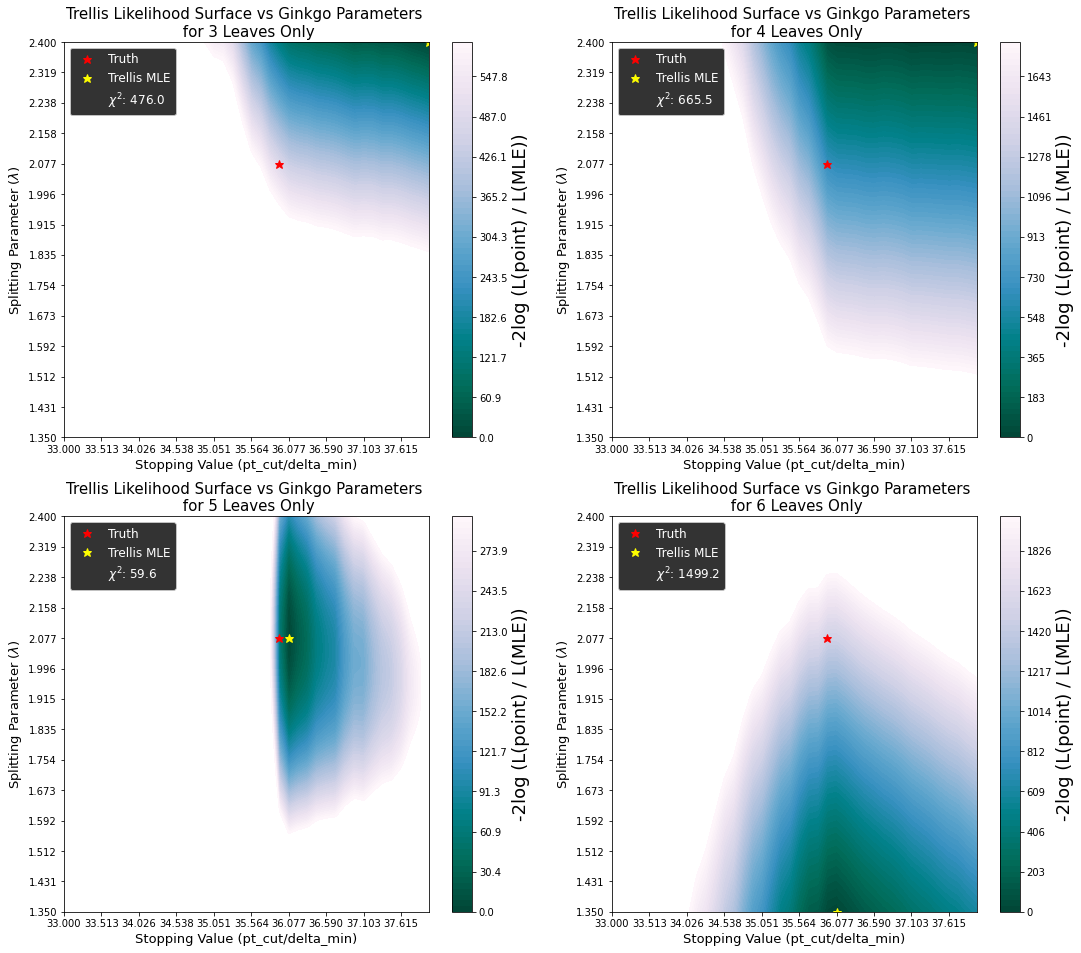

In [271]:
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(18,16)

leaf_choices = np.array([[3, 4], [5, 6]])
vmax_scales = np.array([[600, 1800], [300, 2000]])

for ax_x in range(2):
    for ax_y in range(2):
        
        batch_likelihood_surface = np.sum(likelihood_surface_array[num_leaves == leaf_choices[ax_x, ax_y]], axis=0)
        
        batch_mle_coords = np.unravel_index(np.argmax(batch_likelihood_surface[~np.isnan(batch_likelihood_surface)], axis=None), batch_likelihood_surface.shape)

        Z = -2*(batch_likelihood_surface-batch_likelihood_surface[batch_mle_coords])

        chi2_marginal = Z[truth_bin[1], truth_bin[0]]

        # Boost the upper limit to avoid truncation errors.
        levels = np.linspace(0, vmax_scales[ax_x, ax_y], 70)

        # Contour plot
        cset1 = ax[ax_x,ax_y].contourf(grid_cut, grid_lambda, Z,
                            levels, cmap="PuBuGn_r")
        cb = fig.colorbar(cset1, ax=ax[ax_x,ax_y])
        cb.set_label(label="-2log (L(point) / L(MLE))", size=18)

        ax[ax_x,ax_y].plot(cut_vals[truth_bin[0]], lambda_vals[truth_bin[1]], "*", color="red", markersize=9, label="Truth")
        ax[ax_x,ax_y].plot(cut_vals[batch_mle_coords[1]], lambda_vals[batch_mle_coords[0]], "*", color="yellow", markersize=9, label="Trellis MLE")
        #ax.plot(cut_vals[mle_leaf_coords[1]], lambda_vals[mle_leaf_coords[0]], "*", color="orange", markersize=9, label="Leaf MLE")
        #ax[ax_x,ax_y].plot(cut_vals[mle_map_coords[1]], lambda_vals[mle_map_coords[0]], "*", color="violet", markersize=9, label="MAP MLE")
        ax[ax_x,ax_y].plot([], [], ' ', label="$\chi^2$: {:.1f}".format(chi2_marginal))

        ax[ax_x,ax_y].legend(labelcolor="white", facecolor="black", fontsize="large", loc="upper left")

        ax[ax_x,ax_y].set_title("Trellis Likelihood Surface vs Ginkgo Parameters \n for {} Leaves Only".format(leaf_choices[ax_x, ax_y]), size=15)
        ax[ax_x,ax_y].set_xlabel("Stopping Value (pt_cut/delta_min)", size=13)
        ax[ax_x,ax_y].set_ylabel("Splitting Parameter ($\lambda$)", size=13)
        #ax.set_yscale("log")
        ax[ax_x,ax_y].set_xticks(cut_vals[::4])
        ax[ax_x,ax_y].set_yticks(lambda_vals[::3]);

## Incorporate a factor based on the leaves probability

In [276]:
leaf_distro = np.zeros((118, n_lambda, n_cuts))  # first index is the number of leaves - 1

for i in range(n_cuts):
    for j in range(n_lambda):        
        histfile = "ginkgo_hist_20000_jets_jetp_400_lambda_{:n}_ptcut_{:n}_{}_{}.npy".format(
            int(grid_lambda[j,i])*1000,
            int(grid_cut[j,i]),
            j,
            i)

        log_dist = np.log(np.load(os.path.join("/scratch/mdd424/data/ginkgo", histfile)))
        
        leaf_distro[:, j,i] = log_dist

<ipython-input-276-33a21b9b1568>:11: RuntimeWarning: divide by zero encountered in log
  log_dist = np.log(np.load(os.path.join("/scratch/mdd424/data/ginkgo", histfile)))


In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(18,16)

leaf_choices = np.array([[3, 4], [5, 6]])
vmax_scales = np.array([[600, 1800], [300, 2000]])

for ax_x in range(2):
    for ax_y in range(2):
        
        batch_likelihood_surface = np.sum(likelihood_surface_array[num_leaves == leaf_choices[ax_x, ax_y]], axis=0)
        
        batch_mle_coords = np.unravel_index(np.argmax(batch_likelihood_surface[~np.isnan(batch_likelihood_surface)], axis=None), batch_likelihood_surface.shape)

        Z = -2*(batch_likelihood_surface-batch_likelihood_surface[batch_mle_coords])

        chi2_marginal = Z[truth_bin[1], truth_bin[0]]

        # Boost the upper limit to avoid truncation errors.
        levels = np.linspace(0, vmax_scales[ax_x, ax_y], 70)

        # Contour plot
        cset1 = ax[ax_x,ax_y].contourf(grid_cut, grid_lambda, Z,
                            levels, cmap="PuBuGn_r")
        cb = fig.colorbar(cset1, ax=ax[ax_x,ax_y])
        cb.set_label(label="-2log (L(point) / L(MLE))", size=18)

        ax[ax_x,ax_y].plot(cut_vals[truth_bin[0]], lambda_vals[truth_bin[1]], "*", color="red", markersize=9, label="Truth")
        ax[ax_x,ax_y].plot(cut_vals[batch_mle_coords[1]], lambda_vals[batch_mle_coords[0]], "*", color="yellow", markersize=9, label="Trellis MLE")
        #ax.plot(cut_vals[mle_leaf_coords[1]], lambda_vals[mle_leaf_coords[0]], "*", color="orange", markersize=9, label="Leaf MLE")
        #ax[ax_x,ax_y].plot(cut_vals[mle_map_coords[1]], lambda_vals[mle_map_coords[0]], "*", color="violet", markersize=9, label="MAP MLE")
        ax[ax_x,ax_y].plot([], [], ' ', label="$\chi^2$: {:.1f}".format(chi2_marginal))

        ax[ax_x,ax_y].legend(labelcolor="white", facecolor="black", fontsize="large", loc="upper left")

        ax[ax_x,ax_y].set_title("Trellis Likelihood Surface vs Ginkgo Parameters \n for {} Leaves Only".format(leaf_choices[ax_x, ax_y]), size=15)
        ax[ax_x,ax_y].set_xlabel("Stopping Value (pt_cut/delta_min)", size=13)
        ax[ax_x,ax_y].set_ylabel("Splitting Parameter ($\lambda$)", size=13)
        #ax.set_yscale("log")
        ax[ax_x,ax_y].set_xticks(cut_vals[::4])
        ax[ax_x,ax_y].set_yticks(lambda_vals[::3]);

## Some histograms

In [175]:
n_cuts = 40
n_lambda = 40
N_jets = 5000

#cut_min = 4
#cut_max = 90
#lambda_min = 1e-1
#lambda_max = 5

#cut_min = 26
#cut_max = 43
cut_min = 33
cut_max = 38
lambda_min = 1.35
lambda_max = 2.4

cut_vals = np.linspace(cut_min, cut_max, n_cuts)
lambda_vals = np.linspace(lambda_min, lambda_max, n_lambda)
grid_cut, grid_lambda = np.meshgrid(cut_vals, lambda_vals)

datadir="/scratch/mdd424/data/trellis"

In [145]:
in_filename = os.path.join(datadir, "trellis_1000_jets_lambda_{:n}_ptcut_{:n}_{}_{}.pkl".format(
    int(grid_lambda[mle_coords])*1000,
    int(grid_cut[mle_coords]),
    mle_coords[0],
    mle_coords[1]))
with open(in_filename, "rb") as fd:
    mle_results = pickle.load(fd, encoding='latin-1')

In [177]:
in_filename = os.path.join(datadir, "trellis_10000_jets_lambda_{:n}_ptcut_{:n}_{}_{}_with_perm.pkl".format(
    int(grid_lambda[truth_bin[1], truth_bin[0]])*1000,
    int(grid_cut[truth_bin[1], truth_bin[0]]),
    truth_bin[1],
    truth_bin[0]))
with open(in_filename, "rb") as fd:
    truth_results = pickle.load(fd, encoding='latin-1')

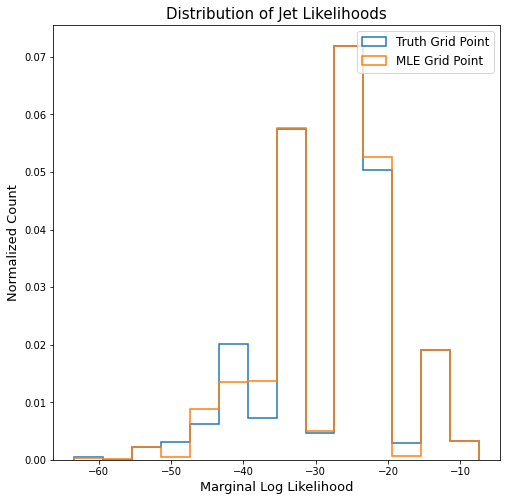

In [156]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(8,8)

low = np.min([np.min(truth_results["Z"]), np.min(mle_results["Z"])])
high = np.max([np.max(truth_results["Z"]), np.max(mle_results["Z"])])

bins = np.linspace(low, high, 15)

ax.hist(truth_results["Z"], bins=bins, histtype="step", linewidth=1.5, density=True, label="Truth Grid Point")
ax.hist(mle_results["Z"], bins=bins, histtype="step", linewidth=1.5, density=True, label="MLE Grid Point")

ax.set_xlabel("Marginal Log Likelihood", size=13)
ax.set_ylabel("Normalized Count", size=13)
ax.set_title("Distribution of Jet Likelihoods", size=15)
ax.legend(fontsize="large")

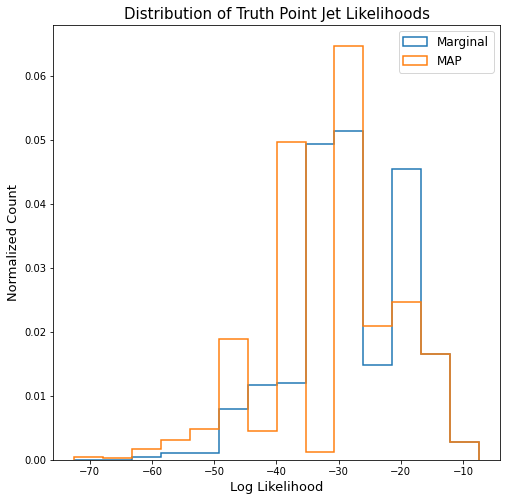

In [155]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(8,8)

low = np.min([np.min(truth_results["Z"]), np.min(truth_results["trellis_MLE"])])
high = np.max([np.max(truth_results["Z"]), np.max(truth_results["trellis_MLE"])])

bins = np.linspace(low, high, 15)

ax.hist(truth_results["Z"], bins=bins, histtype="step", linewidth=1.5, density=True, label="Marginal")
ax.hist(truth_results["trellis_MLE"], bins=bins, histtype="step", linewidth=1.5, density=True, label="MAP")

ax.set_xlabel("Log Likelihood", size=13)
ax.set_ylabel("Normalized Count", size=13)
ax.set_title("Distribution of Truth Point Jet Likelihoods", size=15)
ax.legend(fontsize="large")

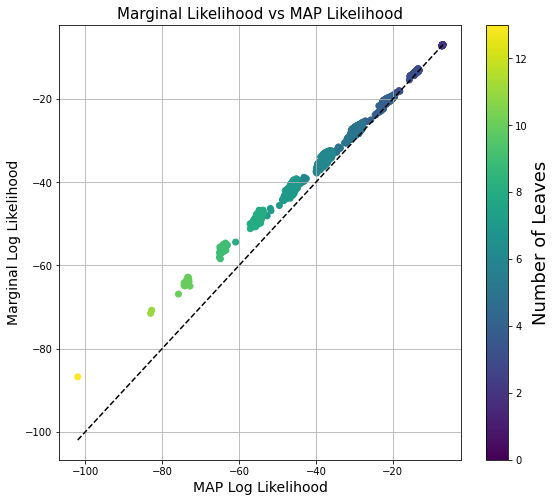

In [209]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,8)

cm = plt.cm.get_cmap('RdYlBu')

arr = np.arange(len(truth_results["Z"]))
good_indices = arr[((arr != 4835) & (arr != 9024))]

x_min = np.array(truth_results["trellis_MLE"])[good_indices].min()
x_max = np.array(truth_results["trellis_MLE"])[good_indices].max()


ax.plot([x_min, x_max],
        [x_min, x_max],
        color="black", linestyle="dashed")
sc = ax.scatter(truth_results["trellis_MLE"], truth_results["Z"], c=truth_results["Nleaves"], vmin=0)#, s=2)

ax.set_xlabel("MAP Log Likelihood", size=14)
ax.set_ylabel("Marginal Log Likelihood", size=14)
ax.set_title("Marginal Likelihood vs MAP Likelihood", size=15)
ax.grid()
cb = plt.colorbar(sc, ax=ax)
cb.set_label(label="Number of Leaves", size=18)

### Load in truth jets

In [212]:
gt_trees = load_jets("data", "ginkgo_10000_jets_no_cuts_lambda_21_pt_min_36_jetp_400_with_perm")  # My test file

In [213]:
gt_trees[0]

{'root_id': 0,
 'tree': array([[ 1,  2],
        [-1, -1],
        [ 3,  4],
        [-1, -1],
        [ 5,  6],
        [-1, -1],
        [ 7,  8],
        [-1, -1],
        [ 9, 10],
        [-1, -1],
        [-1, -1]]),
 'content': array([[401.1234224 , 230.94010768, 230.94010768, 230.94010768],
        [140.70331654,  81.90872456,  86.04075895,  75.30712345],
        [260.42011861, 149.03139046, 144.89935607, 155.63299157],
        [113.75557568,  62.70843971,  66.52840832,  67.5956968 ],
        [146.66454294,  86.32295075,  78.37094775,  88.03729477],
        [ 30.45783174,  18.10387933,  15.88508526,  18.63716155],
        [116.20670984,  68.21907062,  62.48586176,  69.40013241],
        [ 66.49890589,  40.12142408,  34.66924426,  40.12164479],
        [ 49.70780152,  28.0976451 ,  27.81661619,  29.27848616],
        [ 41.84564507,  22.78711591,  25.14414593,  24.15534759],
        [  7.86215645,   5.31052919,   2.67247026,   5.12313857]]),
 'LambdaRoot': tensor(2.1000),
 'Lambd

In [224]:
np.vstack([row for row in gt_trees[0]["content"] if row not in gt_trees[0]["leaves"]])

array([[401.1234224 , 230.94010768, 230.94010768, 230.94010768],
       [260.42011861, 149.03139046, 144.89935607, 155.63299157],
       [146.66454294,  86.32295075,  78.37094775,  88.03729477],
       [116.20670984,  68.21907062,  62.48586176,  69.40013241],
       [ 49.70780152,  28.0976451 ,  27.81661619,  29.27848616]])

In [225]:
non_leaves_t = []
leaves_t = []

for tree in gt_trees:
    for particle in tree["content"]:
        if particle in tree["leaves"]:
            leaves_t.append(particle[0]**2 - np.linalg.norm(particle[1:])**2)
        else:
            non_leaves_t.append(particle[0]**2 - np.linalg.norm(particle[1:])**2)

Text(0.5, 1.0, 'Distribution of $t$ for Leaves')

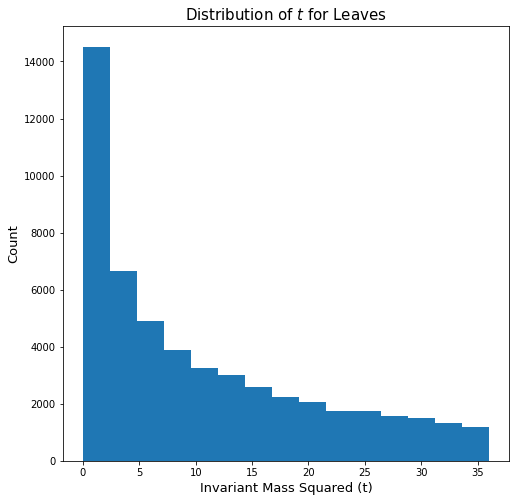

In [236]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(8,8)

#low = np.min([np.min(leaves_t), np.min(non_leaves_t)])
#high = np.max([np.max(leaves_t), np.max(non_leaves_t)])

#bins = np.linspace(low, high, 15)

ax.hist(leaves_t, bins=15, label="Leaves")

ax.set_xlabel("Invariant Mass Squared (t)", size=13)
ax.set_ylabel("Count", size=13)
ax.set_title("Distribution of $t$ for Leaves", size=15)

Text(0.5, 1.0, 'Distribution of $t$ for Non-Leaves')

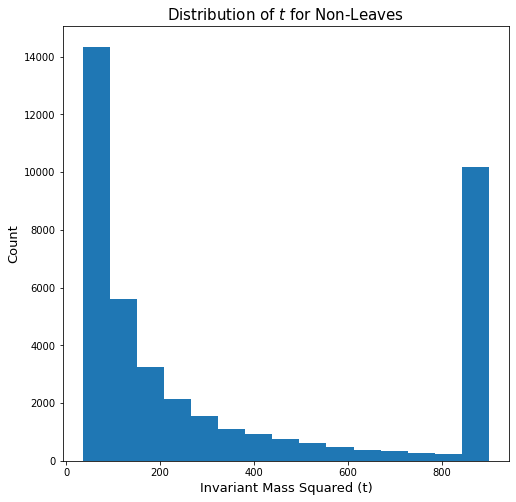

In [237]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(8,8)

#low = np.min([np.min(leaves_t), np.min(non_leaves_t)])
#high = np.max([np.max(leaves_t), np.max(non_leaves_t)])

#bins = np.linspace(low, high, 15)

ax.hist(non_leaves_t, bins=15, label="Leaves")

ax.set_xlabel("Invariant Mass Squared (t)", size=13)
ax.set_ylabel("Count", size=13)
ax.set_title("Distribution of $t$ for Non-Leaves", size=15)
